In [1]:
import sys
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from skimage import measure

from domb.reg_type.wf_x2_m2 import WF_2x_2m as WF
from domb.fret.e_fret.e_app import Eapp
from domb.utils import masking
from domb.utils import plot
from domb.red_green.wt_vs_mut import WTvsMut as WvM

sys.path.append('../src')
from load_save import load_data
from main import analyze_FRET_data

# E-FRET wtih domb

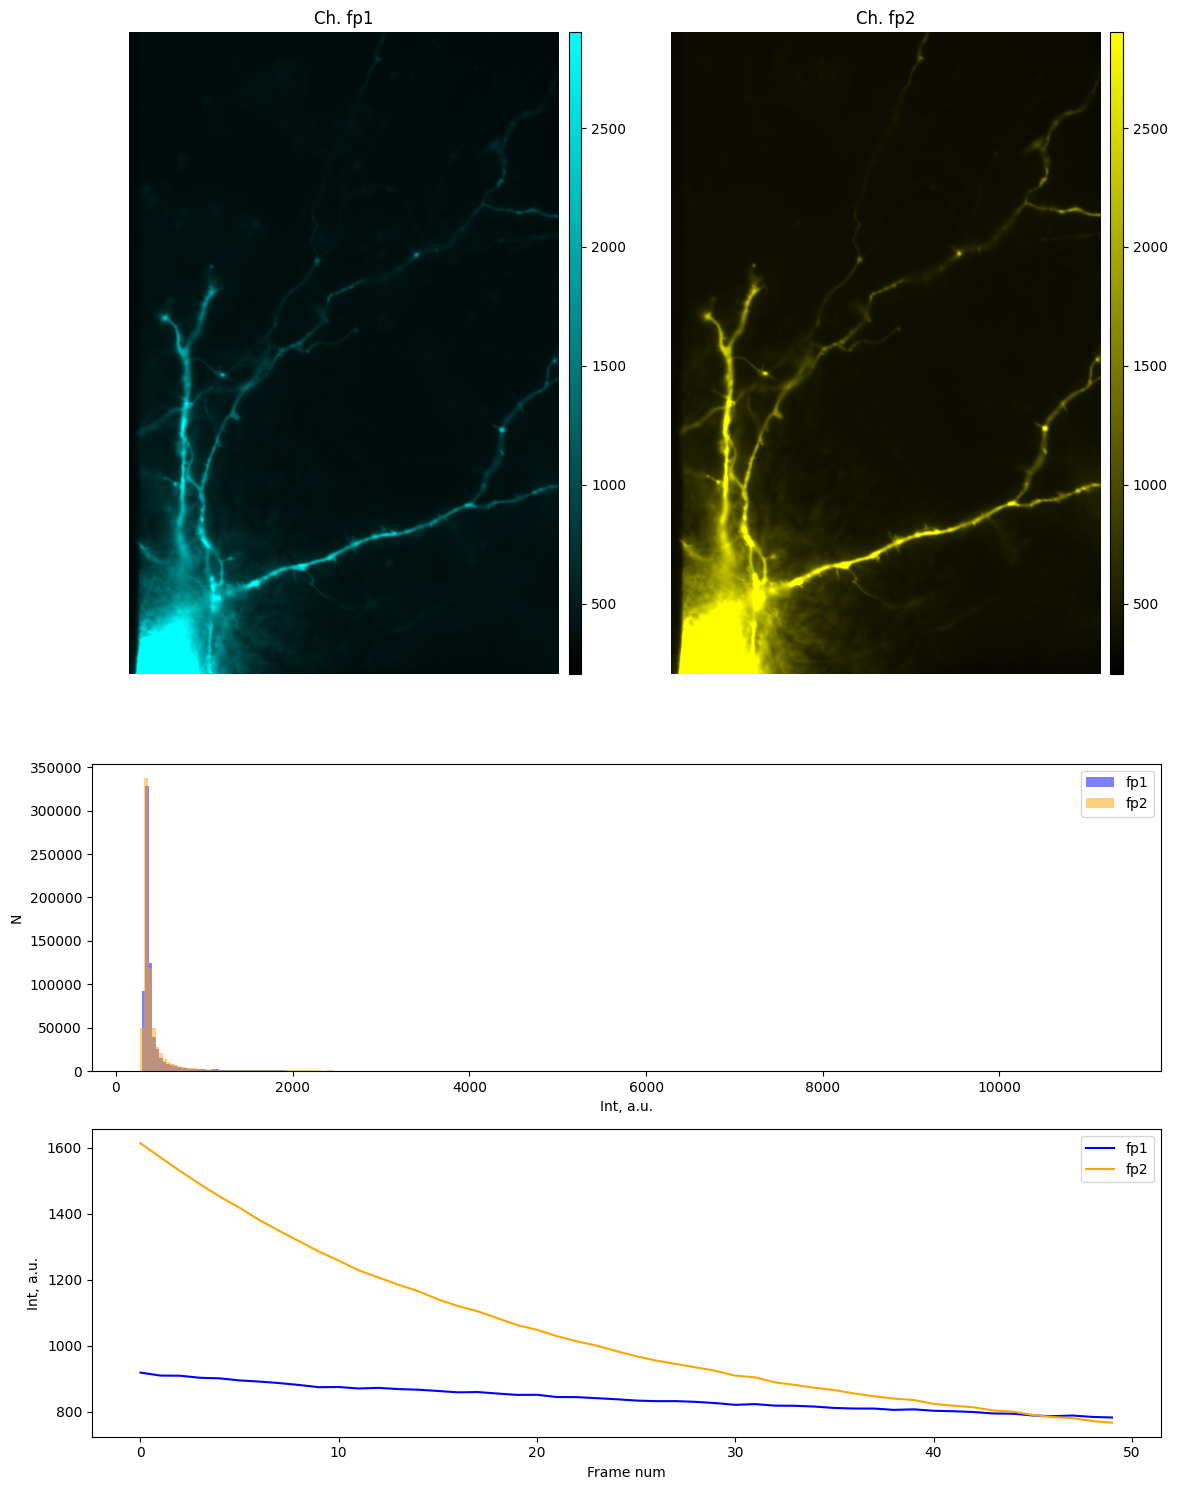

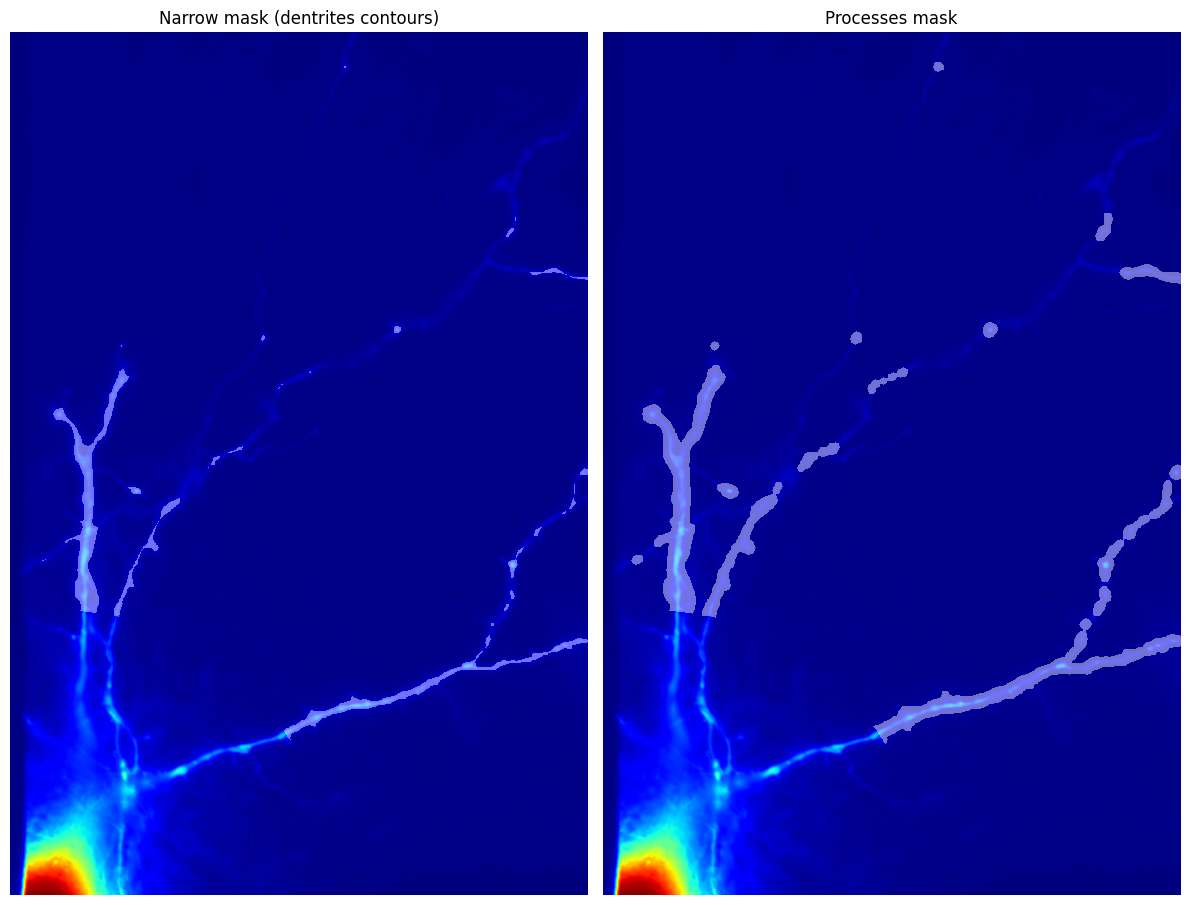

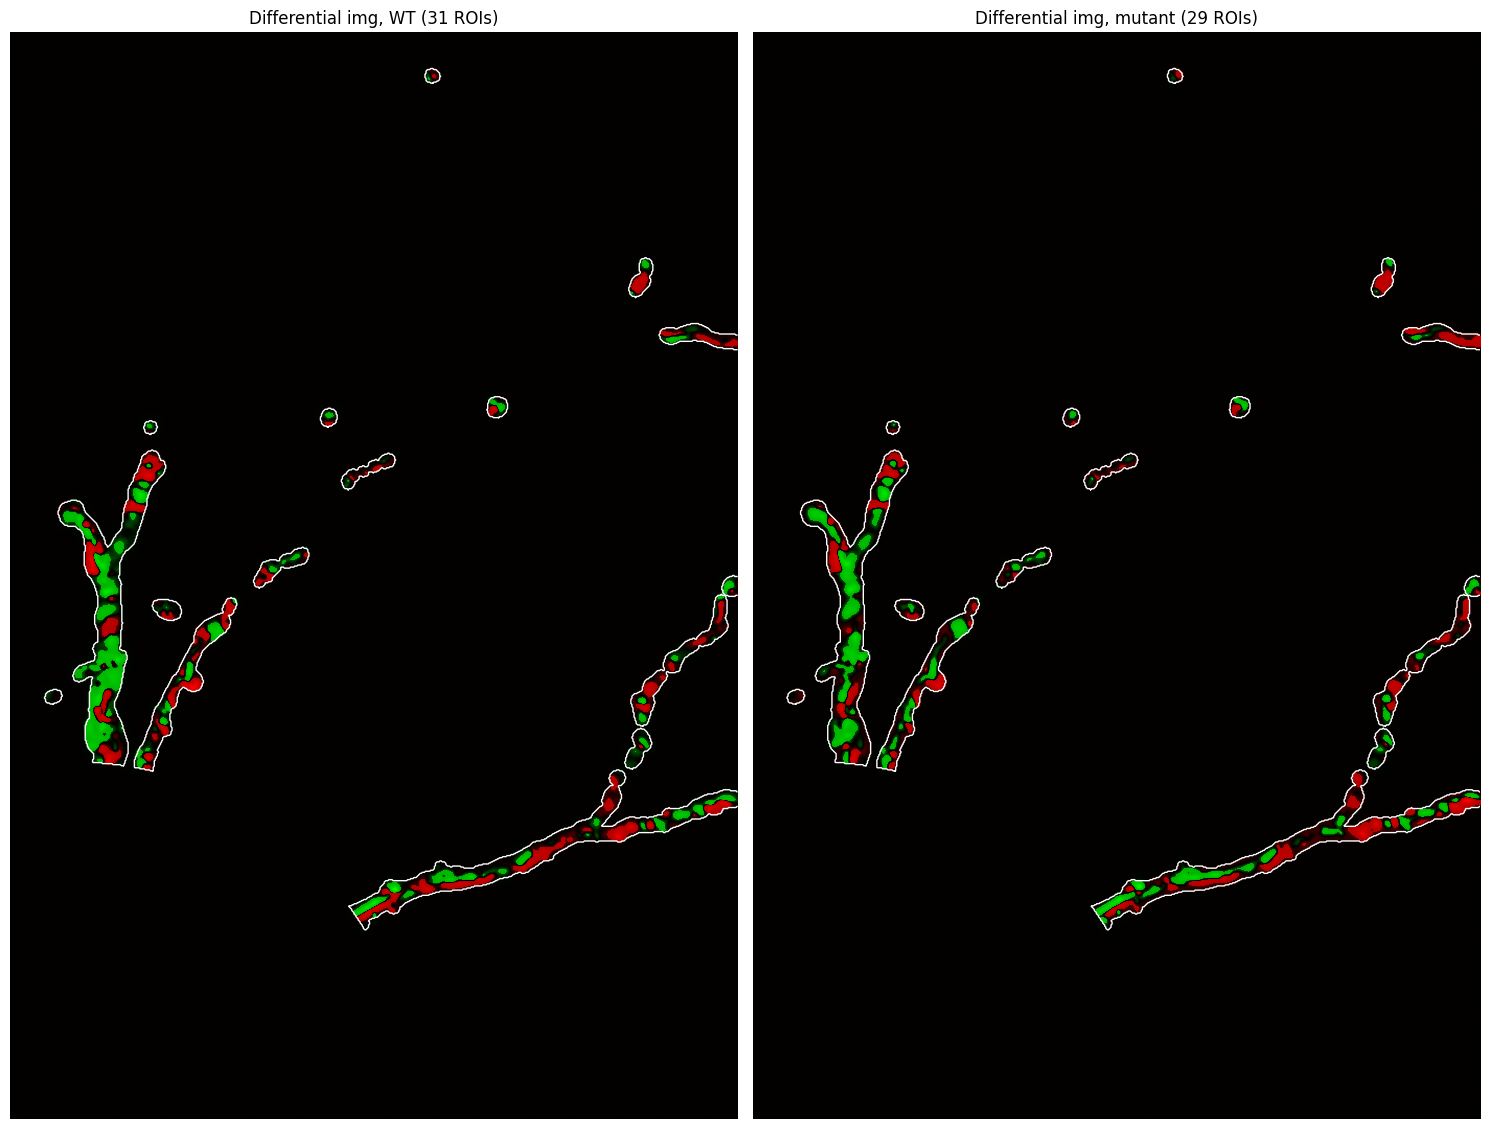

In [2]:
# reg_path = r'demo_data/03.tif'
reg_path = r'demo_data/23_06_23_11.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]


# fp1 - CFP, fp2 - YFP
reg = WF(img_path=reg_path, img_name=reg_name, ch_order={'fp1':0,'fp2':3}, wf_sigma=.75,
         soma_mask=True, soma_th=.7, soma_ext=300, proc_sigma=1)  # processes masking parameters

reg.ch_pic()
reg.processes_mask_pic()


reg_RG = WvM(wt_img=reg.corr_fp1_img,
             mut_img=reg.corr_fp2_img,
             narrow_proc_mask=reg.narrow_proc_mask,
             proc_mask=reg.proc_mask,
             sd_tolerance=1, base_frames=5, stim_start=6, stim_win=10)  # up mask calc parameters

reg_RG.diff_img_pic()

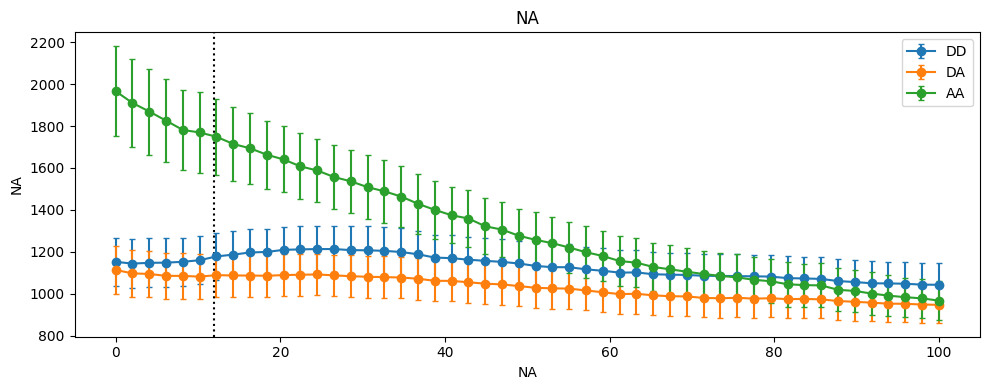

In [3]:
fret_label = measure.label(reg_RG.wt_up_mask)

_,dd_int = masking.label_prof_arr(input_label=fret_label,
                                  input_img_series=reg.img_raw[:,:,:,0])
_,da_int = masking.label_prof_arr(input_label=fret_label,
                                  input_img_series=reg.img_raw[:,:,:,1])
_,aa_int = masking.label_prof_arr(input_label=fret_label,
                                   input_img_series=reg.img_raw[:,:,:,3])

plot.stat_line_plot(arr_list=[dd_int, da_int, aa_int],
                    lab_list=['DD', 'DA', 'AA'],
                    stat_method='ci',
                    figsize=(10,4))

In [5]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=reg.ch0_img,
                da_img=reg.ch1_img,
                ad_img=reg.ch2_img,
                aa_img=reg.ch3_img,
                abcd_list=abcd, G_val=G,
                mask=reg.narrow_proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

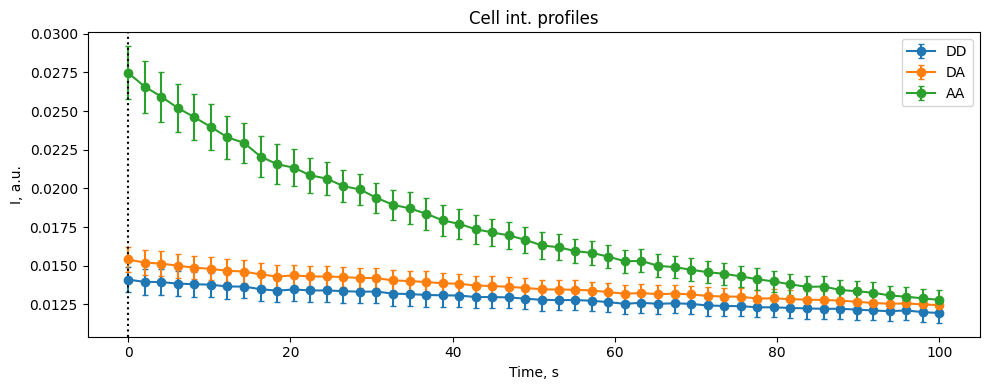

In [6]:
_,dd_prof = masking.label_prof_arr(input_label=measure.label(reg.narrow_proc_mask),
                                   input_img_series=reg_FRET.DD_img)
_,da_prof = masking.label_prof_arr(input_label=measure.label(reg.narrow_proc_mask),
                                   input_img_series=reg_FRET.DA_img)
_,aa_prof = masking.label_prof_arr(input_label=measure.label(reg.narrow_proc_mask),
                                   input_img_series=reg_FRET.AA_img)

dd_mean = np.mean(dd_prof, axis=0) 
dd_sd = np.std(dd_prof, axis=0)
da_mean = np.mean(da_prof, axis=0) 
da_sd = np.std(da_prof, axis=0)
aa_mean = np.mean(aa_prof, axis=0) 
aa_sd = np.std(aa_prof, axis=0) 

plot.stat_line_plot(arr_list=[dd_prof, da_prof, aa_prof],
                    lab_list=['DD', 'DA', 'AA'],
                    stat_method='ci', stim_t=False,
                    figsize=(10,4), x_lab='Time, s', y_lab='I, a.u.', plot_title='Cell int. profiles')

In [ ]:
_,cell_fret = masking.label_prof_arr(input_label=measure.label(reg.narrow_proc_mask),
                                     input_img_series=reg_FRET.Ecorr_img)

fret_mean = np.mean(cell_fret, axis=0)
fret_sd = np.std(cell_fret, axis=0)

plot.stat_line_plot(arr_list=[cell_fret],
                    lab_list=['cell'],
                    stat_method='ci', stim_t=False,
                    figsize=(10,4), x_lab='Time, s', y_lab='Eapp', plot_title='Eapp profiles')

# B-FRET

In [ ]:
b_fret_data = {'IDD':aa_mean - 0.03,
               'IDA':da_mean,
               'IAA':aa_mean,
               'E':fret_mean,
               'tDD':np.linspace(0, dd_mean.shape[0], num=dd_mean.shape[0]),
               'tAA':np.linspace(0, aa_mean.shape[0], num=aa_mean.shape[0]),
               'IDD_noise_sd':dd_sd,
               'IDA_noise_sd':da_sd,
               'IAA_noise_sd':aa_sd,
               'crstlk':{'a':abcd[0], 'd':abcd[-1], 'G':G}}

In [ ]:
DATA_DIR = r'../example'
data = load_data(DATA_DIR, 'data_sinusoids')
print(data['crstlk'])
print(b_fret_data['crstlk'])

In [ ]:
EXP_DIR = r'demo_data/exp_dir/'
	
a = analyze_FRET_data(b_fret_data, EXP_DIR)
a.run()

In [ ]:
for k in a.b.pred.keys():
    print(f'{k}: {len(a.b.pred[k])}')

In [ ]:


plt.figure(figsize=(12,5))
plt.plot(data['tDD'], data['E'][0], label='signal')
plt.plot(data['tDD'], a.b.pred['E_FRET_corr'], alpha=.5, label='Eapp')
plt.plot(data['tDD'], a.b.pred['E_med'], label='predicted')
plt.xlabel('Time, s')
plt.ylabel('Eapp')
plt.legend()
plt.show()